# Data analysis of Kepler-16 system, real-life Tatooine
##### Tomáš Chobola


## 1. Abstract
In this notebook I try to replicate the photometry introduced in paper called [*Kepler-16: A Transiting Circumbinary Planet*](https://arxiv.org/pdf/1109.3432.pdf) using the `Lightkurve` package for Kepler & TESS time series analysis in Python. The Kepler-16 is a binary system with a discovered planet orbiting the pair of low-mass starts. The scientists were able to detect drops in observed brightness based on the photometric data provided by the NASA *Kepler* spacecraft.

Discovering new planets is possible thanks to the *Kepler* telescope monitoring fileds in the constallations Cyngus and Lyra. The telescope finished it's work after almost ten years of monitoring stars in November 15, 2018. The key instrument on the telescope was a photometer that was reposnisble for observations of the visible stars.

## 2. Data preparation
For the analysis I have imported the `Lightcurve` package that has all the necessary functions for processing the light curves. I have also included libraries for plotting and work with array objects.

In [1]:
import lightkurve as lk
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The `Lightcurve` package offers functions for loading data about certain star based solely on it's name or identification number from the Kepler Input Catalog.

In [2]:
star_name = 'Kepler-16'
pixelfile = lk.search_targetpixelfile(star_name, quarter=5).download()

The loaded files are representing images (Target Pixel Files) taken by the telescope during the observations. Each image corresponds with a timestamp of the time the photometer observed the star. I specified fifth quarter (observation period) in the function just for the sake of demonstration purposes.
The image consists of few pixels showcasing the star visibility and brightness.

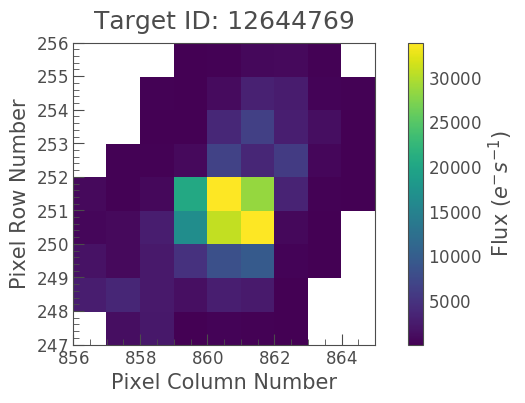

In [3]:
pixelfile.plot()

In [4]:
pixelfile.header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-18'         / file creation date.                            
CREATOR = '885885 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.23 r60353' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

Atribute *shape* has information about the image.

In [5]:
pixelfile.shape

(4492, 9, 9)

The flux data is a 4492x9x9 array in units electrons/second describing the star brightness.

It is possible to highlight the star in the image by applying mask over the grid.

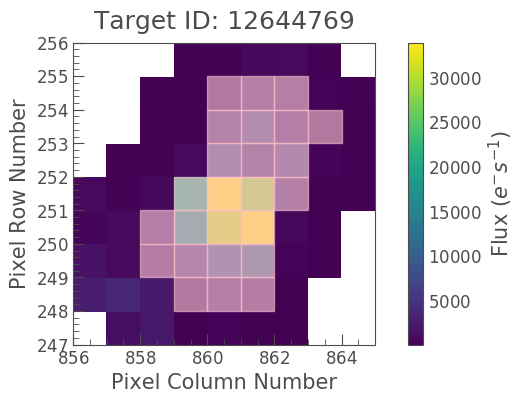

In [6]:
pixelfile.plot(aperture_mask = pixelfile.pipeline_mask);

After gaining some background information about how the telescope observes the star I can start to analyze the light curves of the Kepler-16. Light curve is a graph of light intensity monitored by the instruments. Based on the observed drops I can determine whether there is something transitioning in front of the star (from our point of view) or not.

When observing emitted brightness of a object it is important to take into account the possible outcomes. Let's say the object is a close star without any planets orbiting and no noise between the star and our observing point. The star doesn't emit constant radiation so there will be some deviations. The representation of this can be a simple `sin` function (in reality the light curve looks quite different even for planetless stars due to the mentioned noise).

What am I looking for is a drop in the observed brightness of the star caused by orbiting object. This can be demonstrated by artificially changing the values from the previous function.

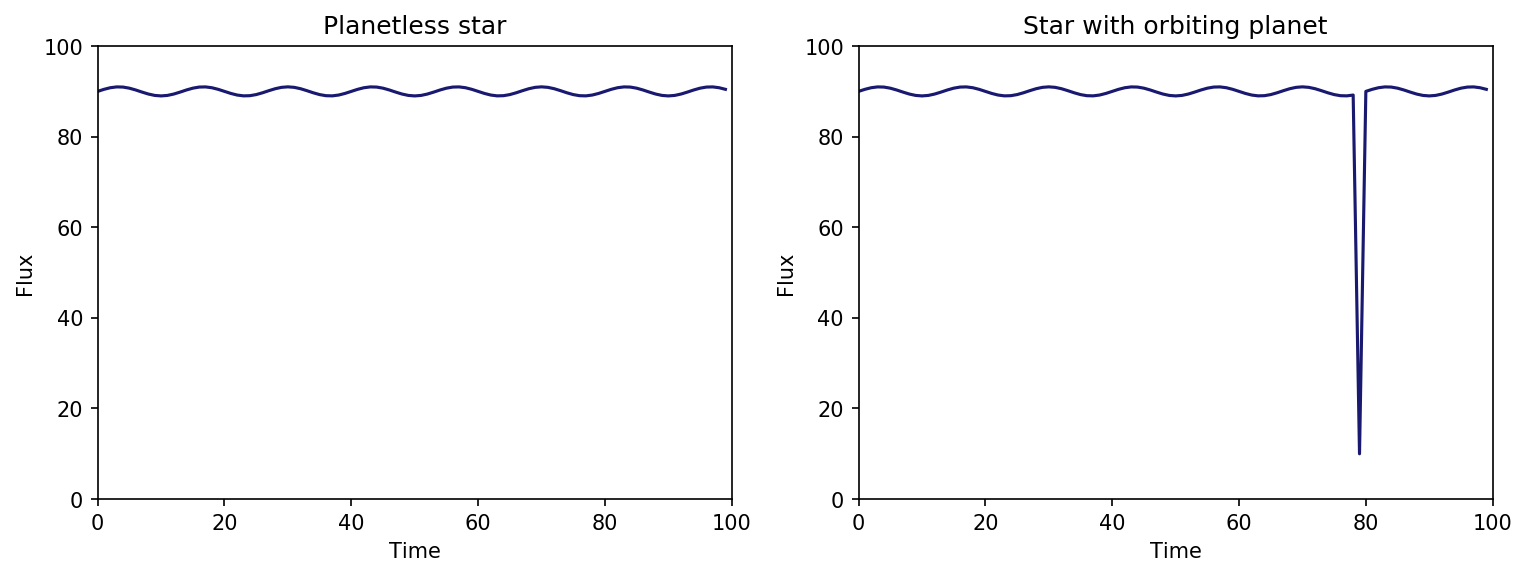

In [7]:
sample = 100
x = np.arange(sample)
y = np.sin(np.pi * 15 * x / 100)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=150)

# ax1 represents planetless star
ax1.plot(x, y + 90, color = 'midnightblue')
ax1.axis((0, 100, 0, 100))
ax1.set_title("Planetless star")
ax1.set_xlabel('Time')
ax1.set_ylabel('Flux')

# ax2 represents drop in observed brightness caused by transit
y[79:80] = -80
ax2.plot(x, y + 90, color = 'midnightblue')
ax2.axis((0, 100, 0, 100))
ax2.set_title("Star with orbiting planet")
ax2.set_xlabel('Time')
ax2.set_ylabel('Flux')

plt.show()

Now I can import the real light curves and analyze them. First I download the data from the first quarter.

In [8]:
lc = lk.search_lightcurvefile(star_name, quarter=1).download()

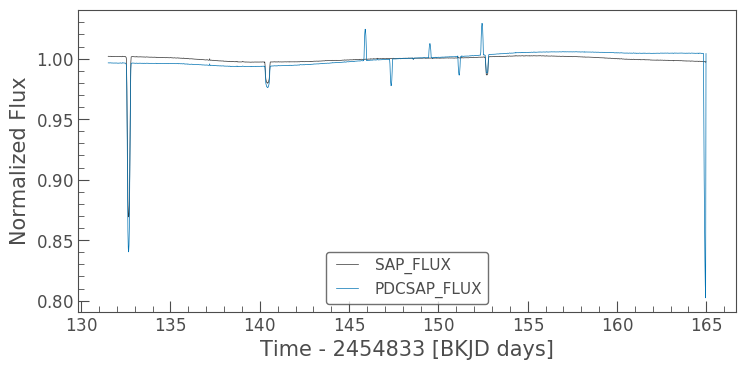

In [9]:
lc.plot()

The imported light curve has two parts, `SAP_FLUX` (Simple Aperture Photometry flux) and `PDCSAP_FLUX` (Pre-search Data Conditioning SAP flux). In this analysis I will use the `PDCSAP_FLUX` since it is a little cleaner.

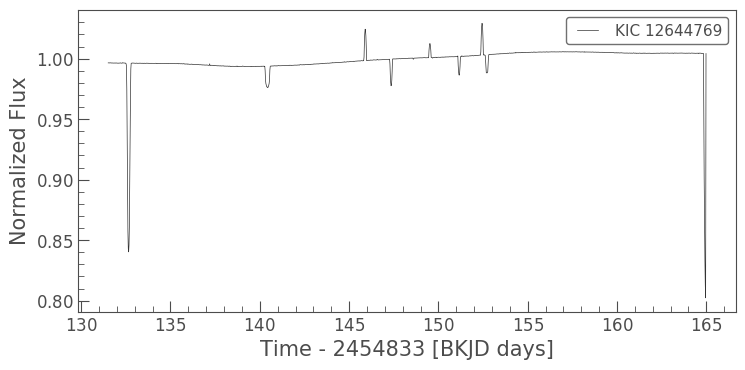

In [10]:
lc = lc.PDCSAP_FLUX
lc.plot()

In [11]:
lc.time

array([131.51204968, 131.53248397, 131.55291816, ..., 164.9422947 ,
       164.96272865, 164.98316271])

According to the paper the orbital period of the planet is 229 days and the period of the first quarter is 89 days so it is impossible for me to observe some periodically repeating occurrences of the planet blocking out the star. In order to do that I have to add data from following quarters.

Because the spacecraft changed positions between the quarters the light might fell on different pixels and it is necessary to normalize the data. Between the observations the temperature of the telescope could change and interfere with readings as well.

In [12]:
lc = lk.search_lightcurvefile(star_name, quarter=1).download().PDCSAP_FLUX.normalize()
for q in range(2,10):
    lc = lc.append(lk.search_lightcurvefile(star_name, quarter=q).download().PDCSAP_FLUX.normalize())

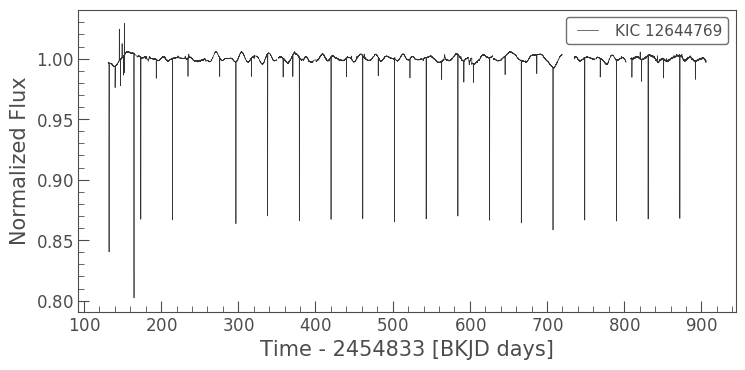

In [13]:
lc.plot()

To remove the trends in the graph I need to flatten the data.

In [14]:
lc = lc.flatten(window_length=301)

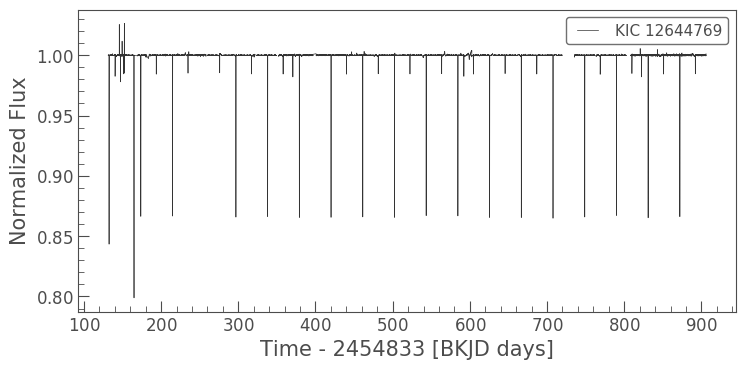

In [15]:
lc.plot()

I can see from the graph there are some missing values and inconsistencies. To analyse the transits I do not need the entirety of the dataset so I can cut out the beginning of the observations. I also remove the NaN values.

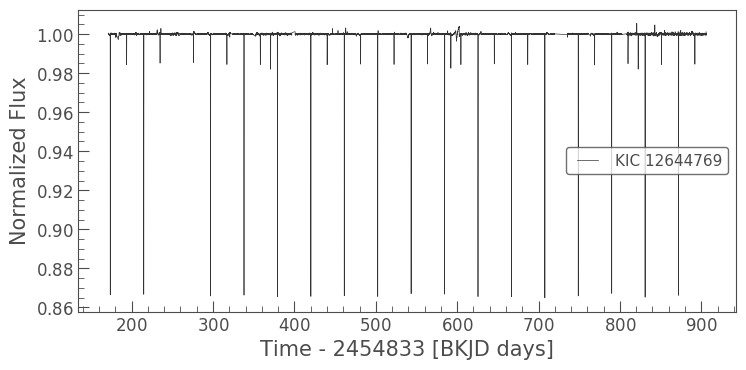

In [16]:
lc = lc[1700:].remove_nans()
lc.plot()

Now I have data prepared for analysis and I can start detecting changes in the star brightness and perceive the movement in the system.

## 3. Data analysis

The Kepler-16 is a binary star system which means that the discovered planet is orbiting pair of stars. This causes an interesting situation in our observations. Not only that the planet is causing drops in the observed brightness, the transits of the stars are responsible for the drops as well.
From the information gather by the team of scientists the stars are quite different in size and luminosity. The first star, Kepler-16A, has radius 0.6489 R<sub>☉</sub> and luminosity 0.148 L<sub>☉</sub>. The second star, Kepler-16B, is smaller in size but it's luminosity is much lower. The radius is 0.2026 R<sub>☉</sub> and luminosity ~0.006 L<sub>☉</sub>. This leads to the conclusion that when star B eclipses star A the drop in observed brightness will be much more significant compared to the scenario when the star A occults star B.

Apart from the movement of the stars the planet Kepler-16b is also responsible for the decrease in the apparent brightness of the system. As the planet has much smaller radius than the stars A and B the predicted effect on the flux should not be so significant. Thus I am looking for four types of transits and changes in measured light.
When analysing the plot I can spot three periodically repeating drops, which two of them are happening relatively shortly after each other and one has longer interval between each appearance. From that I deduce the two repeating events are signaling the conjuction of the stars and the less often event is produced by the planet transitioning in frot of the star A since it has the biggest effect on the luminosity of the system.

The remaining drop created by the planet blocking the light from the star B should be in a close distance from the transit in front of the star A. It is the event that is going to be most challenging to find.

In [17]:
# This function is responsible for finding transits and drops in brightness of the observed system.
def transit_finder(time, flux):
    A_B_flux = np.array([]) # flux levels star A occulting star B
    A_B_time = np.array([]) # timestamps of star A occulting star B
    B_A_flux = np.array([]) # flux levels star B eclipsing star A
    B_A_time = np.array([]) # timestamps of star B eclipsing star A
    b_A_flux = np.array([]) # flux levels of planet b and star A transits
    b_A_time = np.array([]) # timestamps of planet b and star A transits
    b_B_flux = np.array([]) # flux levels of planet b and star B transits
    b_B_time = np.array([]) # timestamps of planet b and star B transits
    
    transition_n = 0
    flux_min = 1
    flux_time = 0
    i = 0
    # Iterates through the whole dataset.
    while (i < len(flux)):
        # When it gets into the critical section (the flux drops under 0.9992), it iterates 
        # until it gets out (the flux rises up above 0.9992 again) and finds the lowest
        # measured flux value. The number 0.9992 provides the most accurate results.
        # While looking at the plot I can predict I am looking for total of 37 events.
        # The spacecraft monitored 16 events of star B eclipsing star A, 15 events of star A occulting
        # star B and 3 transits of planet in front of the star A accompanied by the same amount
        # of passes in front of the star B.
        while (flux[i] < 0.9992):
            if (flux[i] < flux_min):
                flux_min = flux[i]
                flux_time = time[i]
            i += 1
            
        # If the previous iteration found transit of planet b in front of the star A (based on the lowest
        # flux value), this section finds the closest drop caused by the star A shielding the star B.
        # When the drop is found, the new interval is created and used for finding the transit of planet b
        # in front of star B.
        if ((flux_min < 0.983) and (flux_min > 0.96)):
            j = i - 800
            if (j < 0): j = 0
                
            # Looking for the event of star A occulting star B in specified interval.
            interval = flux[j:j + 1600]
            drop_flux = 1
            drop_index = 0
            for f in range(len(interval)):
                # Skipping the flux drops caused by transits of planet b in front of the star A. 
                if ((j + f > i - 100) and (j + f < i + 100)):
                    continue
                
                # Finding the closest event of star A occulting star B (which is defined by drops
                # in specified interval).
                if ((flux[j + f] < 0.99) and (flux[j + f] > 0.984)):
                    if (flux[j + f] < drop_flux):
                        drop_flux = flux[j + f]
                        drop_index = j + f
                        
            if (drop_index < i): 
                start, end = drop_index + 100, i - 100
            else: 
                start, end = i + 100, drop_index - 100
                
            # Finding the transit of the planet b in front of the star B. I am looking for
            # the minimal flux value that corresponds with observed brightness decrease caused by the transit.
            interval = flux[start:end]
            drop_flux = 1
            drop_index = 0
            for x in range(len(interval)):
                if ((flux[start + x] < 1) and (flux[start + x] > 0.98)):
                    if (flux[start + x] < drop_flux):
                        drop_flux = flux[start + x]
                        drop_index = start + x
                    
            # Check if the transit was found
            if (drop_flux != 1):
                b_B_flux = np.append(b_B_flux, flux[drop_index])
                b_B_time = np.append(b_B_time, time[drop_index])
            
            
        # The function found the critical section in this iteration.
        if (flux_time != 0):
            # star B eclipses star A
            if (flux_min < 0.88):
                B_A_flux = np.append(B_A_flux, flux_min)
                B_A_time = np.append(B_A_time, flux_time)
            # planet b transits star A
            elif (flux_min < 0.983):
                b_A_flux = np.append(b_A_flux, flux_min)
                b_A_time = np.append(b_A_time, flux_time)
            # star A occults star B
            elif (flux_min < 0.99):
                A_B_flux = np.append(A_B_flux, flux_min)
                A_B_time = np.append(A_B_time, flux_time)
                
            flux_min = 1
            flux_time = 0
            
        i += 1
        
    return A_B_flux, A_B_time, B_A_flux, B_A_time, b_A_flux, b_A_time, b_B_flux, b_B_time

In [18]:
A_B_flux, A_B_time, B_A_flux, B_A_time, b_A_flux, b_A_time, b_B_flux, b_B_time = transit_finder(lc.time, lc.flux)

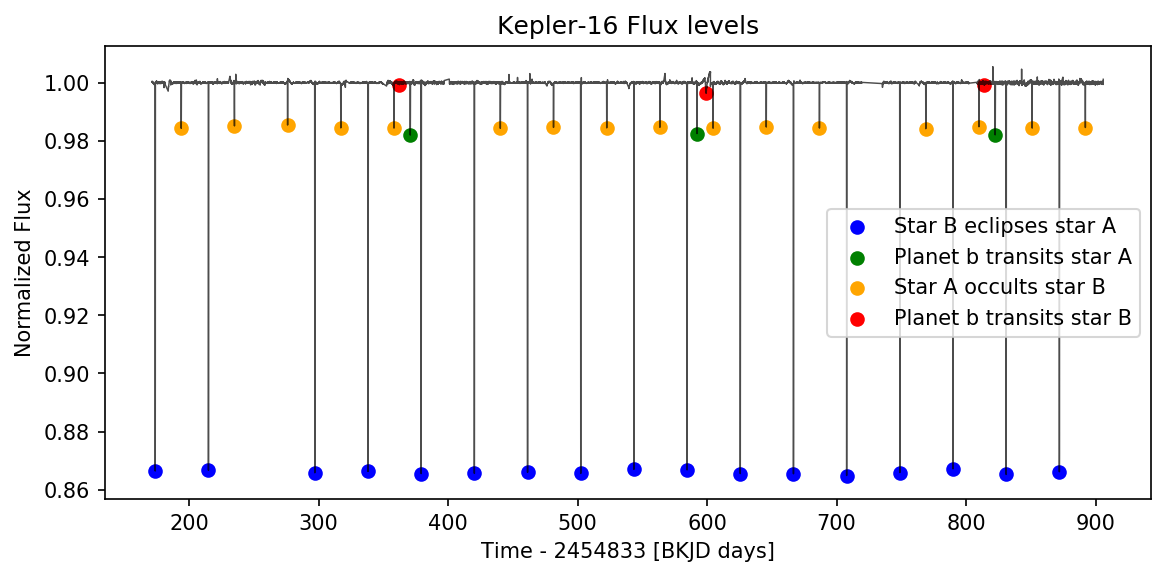

In [19]:
plt.figure(figsize=(9,4), dpi=150)
plt.plot(lc.time, lc.flux, color='black', alpha=0.7, linewidth=0.7)
plt.scatter(B_A_time, B_A_flux, color='blue', label='Star B eclipses star A')
plt.scatter(b_A_time, b_A_flux, color='green', label='Planet b transits star A')
plt.scatter(A_B_time, A_B_flux, color='orange', label='Star A occults star B')
plt.scatter(b_B_time, b_B_flux, color='red', label='Planet b transits star B')
plt.xlabel('Time - 2454833 [BKJD days]')
plt.ylabel('Normalized Flux')
plt.title('Kepler-16 Flux levels')
plt.legend(loc='center right')
plt.show()

The function `transit_finder` is able to recognize the observed transitions. That is possible thanks to the specified intervals of flux levels. Those I estimated from examination of the original graph and the paper mentioned in the abstract chapter of this analysis.
Observing the *blue* events is fairly easy since they have the biggest impact on the analysed brigtness of the system. When looking for this event I analysed all drops in flux undex value 0.88.
The *green* events are needed to be distinguished from the *orange* events. For that I used the photometry analysis described in the paper and I realized that unlike in the *orange* events, when the planet b eclipses star A the flux value drops under value 0.983. By that I was able to differentiate between those events.
Capturing then the *orange* events is not difficlut and I retrieved all values that droped under 0.99.
Finding the *red* transits just by eye is practicly impossible. What helped me was the information that those events occur closely to the *green* events. They can be only observed happening between star A occulting star B and planet b trnasiting in front of the star A. Therefore if I found the *green* event I searched the proximity of the transit and when I found the closest *orange* event I analysed the interval and searched for biggest drops in that interval. That proved itself as a correct approach I was able to detect the transits.

#### Analysed intervals
- Star B eclipses star A - (0, 0.88)
- Planet b transits star - (0.88, 0.93)
- Star A occults star B - (0.93, 0.99)
- Planet b transits star B - (0.99, 1)

From the drops I can also determine the orbital periods of the objects in the system.

In [20]:
def orbital_period(time_data):
    if (time_data.size == 1):
        return time_data[0]
    
    sum = 0
    for i in range(len(time_data) - 1):
        sum += time_data[i + 1] - time_data[i]
        
    return sum/(time_data.size - 1)

In [21]:
# Because there are some missing readings I am only going to use the part that has the periodically repeating dips.
orbital_period(B_A_time[3:17])

41.07633202135688

In [22]:
orbital_period(A_B_time[5:12])

41.078547901635226

From the results I can calculate the orbital period of the star Kepler-16B which is approximately 41.077 days. The original paper stated that the star has eccentric 41-day orbit so the calculation is accurate.

In [23]:
orbital_period(b_A_time)

225.86298491144407

In [24]:
orbital_period(b_B_time)

225.90368788552587

According to the results the orbital period of the planet Kepler-16b is 225.884 days. This value is slightly off from the measurements done by the team of scientists. They stated that the planet has 229-day orbit. This inaccuracy could be caused by imperfections of the readings and small amount of actual observations. If I worked with longer light curve with more apparent transits the number would have been more precise. Although it gives pretty good estimation of the time the planet needs to circle the two stars.

## 4. Visualisation of the transits

To visualise the drop I can simply cut out the parts of the plot to acquire the desired transits.

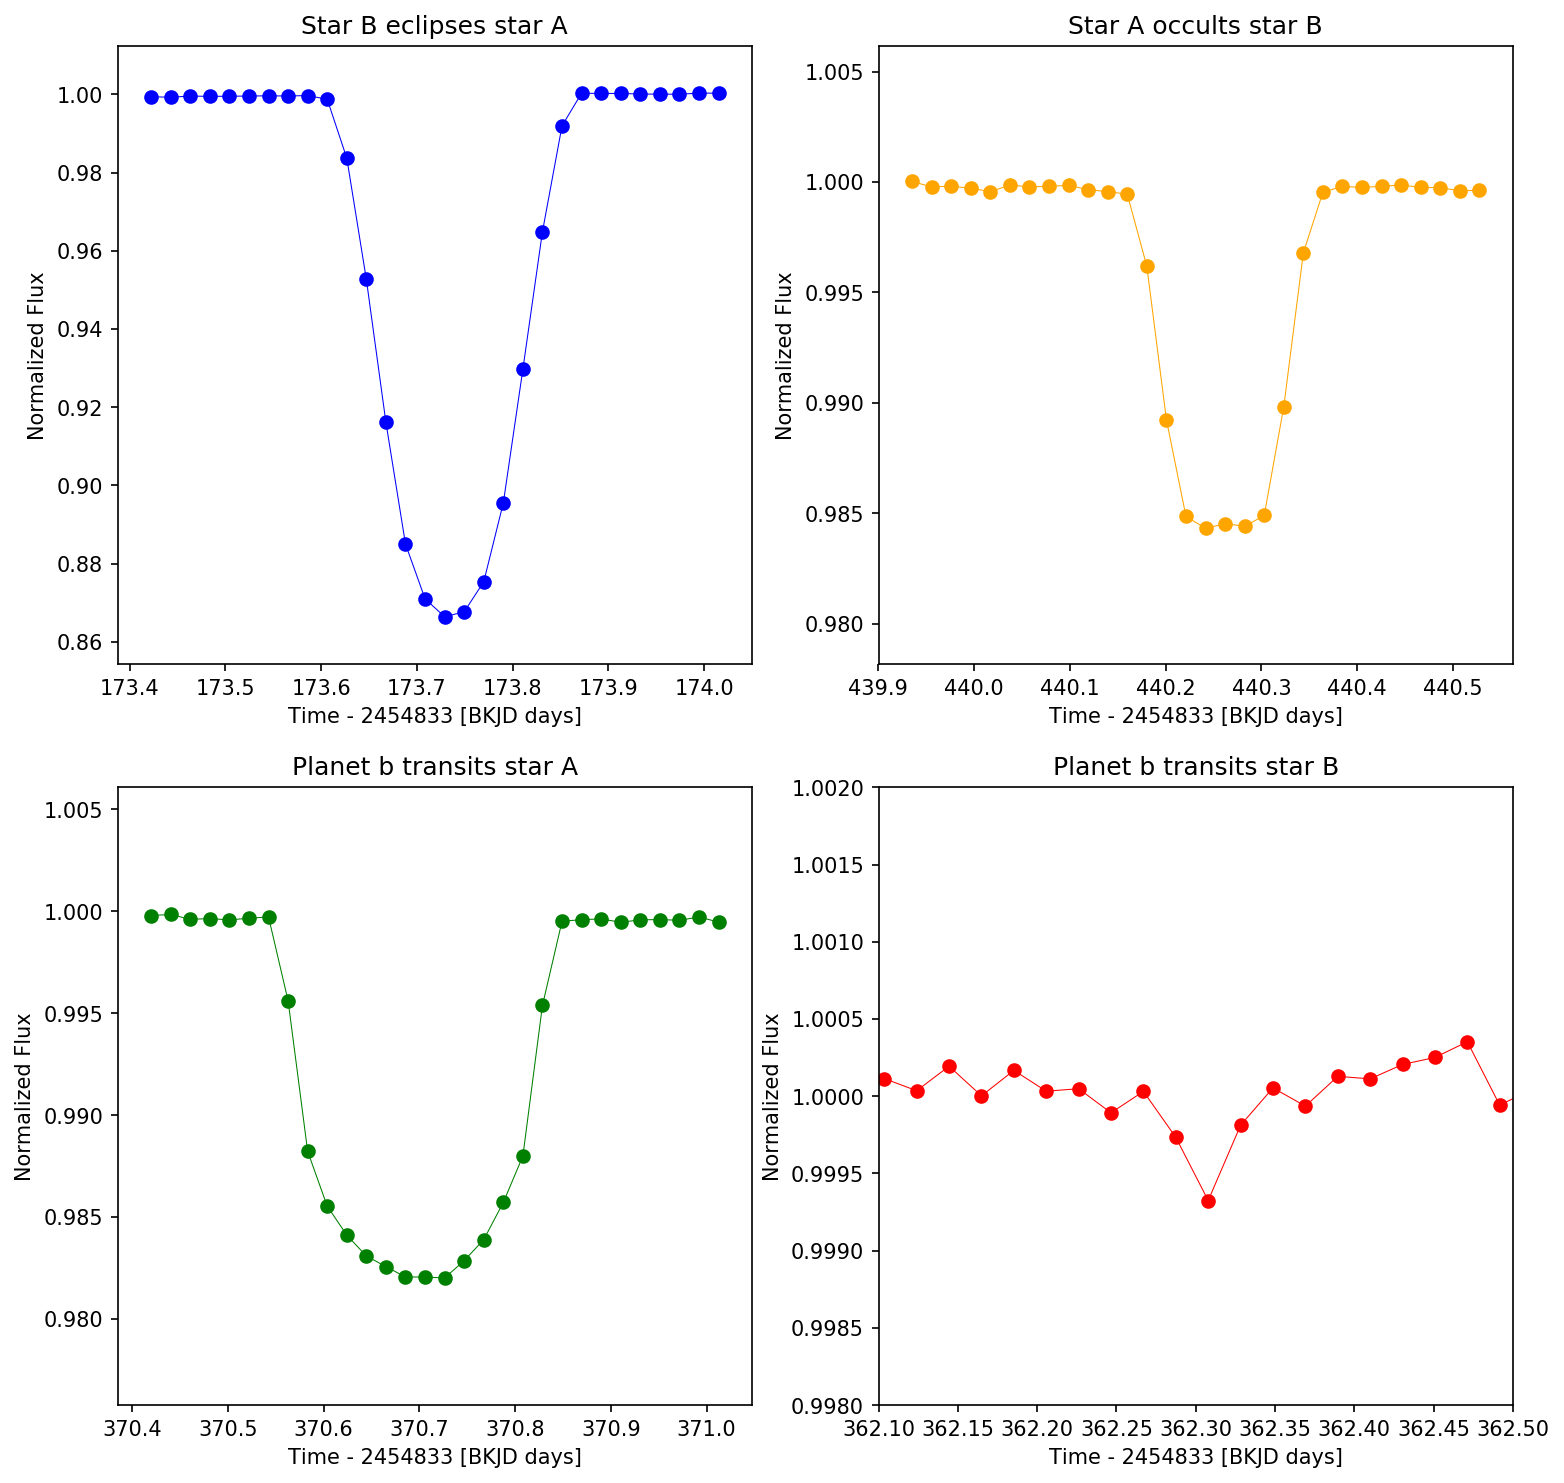

In [25]:
fig, ((bx1, bx2), (bx3, bx4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi=150)

index = np.argwhere(lc.time == B_A_time[0])[0][0]

bx1.scatter(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='blue')
bx1.plot(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='blue', linewidth=0.5)
bx1.set_xlabel('Time - 2454833 [BKJD days]')
bx1.set_ylabel('Normalized Flux')
bx1.set_title('Star B eclipses star A')

index = np.argwhere(lc.time == A_B_time[5])[0][0]

bx2.scatter(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='orange')
bx2.plot(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='orange', linewidth=0.5)
bx2.set_xlabel('Time - 2454833 [BKJD days]')
bx2.set_ylabel('Normalized Flux')
bx2.set_title('Star A occults star B')

index = np.argwhere(lc.time == b_A_time[0])[0][0]

bx3.scatter(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='green')
bx3.plot(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='green', linewidth=0.5)
bx3.set_xlabel('Time - 2454833 [BKJD days]')
bx3.set_ylabel('Normalized Flux')
bx3.set_title('Planet b transits star A')

index = np.argwhere(lc.time == b_B_time[0])[0][0]

bx4.scatter(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='red')
bx4.plot(lc[index-15:index+15].time, lc[index-15:index+15].flux, color='red', linewidth=0.5)
bx4.set_xlabel('Time - 2454833 [BKJD days]')
bx4.set_ylabel('Normalized Flux')
bx4.set_title('Planet b transits star B')
bx4.axis((362.1, 362.5, 0.998, 1.002))

plt.show()

There plots are matching representation of those presented in the paper. 

Next step would be folding the data to remove noise and get even more precise representation of the flux dips caused by the binary star system. I am going the analyse the most visible transit since other decreases in flux are not as significant and could create a lot of unwanted noise. I already created function to calculate the orbital period of the star B so I can use the function here. I cut out parts of the scatter plot to visualise the transit even better.

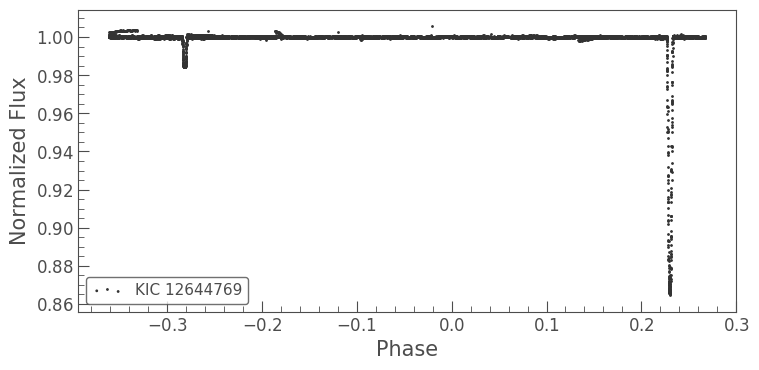

In [52]:
tmp_lc = lc

# terminating the dips caused by transits of planet b
for i in range(len(b_A_time)):
    index = np.argwhere(lc.time == b_A_time[i])[0][0]
    tmp_lc.flux[index-15:index+15] = 1

tmp_lc.fold(orbital_period(B_A_time[3:17]))[4000:25000].scatter()

The orbital period of star B is quite high so for better visualisation I separated the scatter plot into two parts so it is better for analysis.

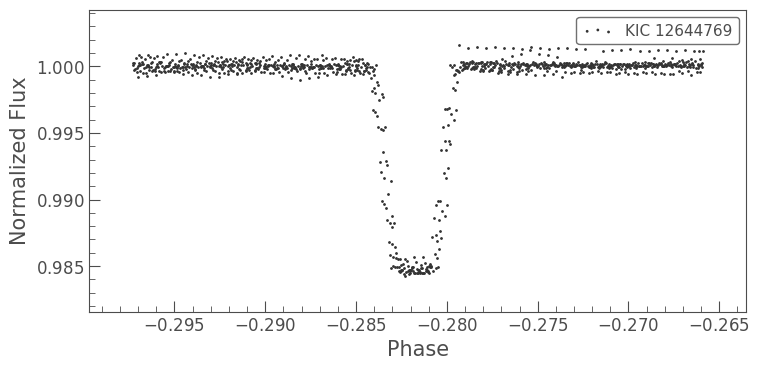

In [59]:
# Star A occults star B
tmp_lc.fold(orbital_period(B_A_time[3:17]))[6000:7000].scatter()

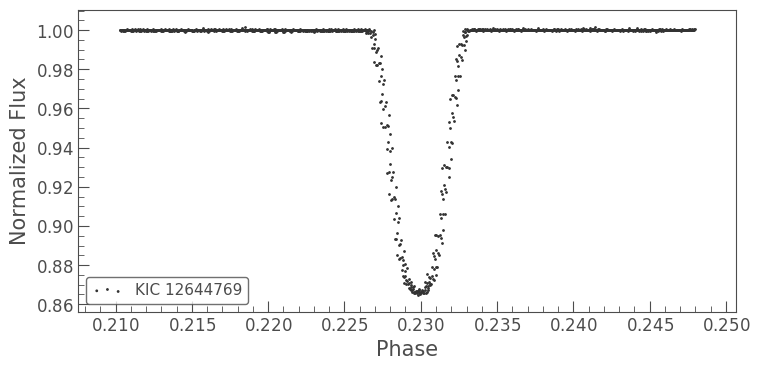

In [65]:
# Star B eclipses star A
tmp_lc.fold(orbital_period(B_A_time[3:17]))[23000:24300].scatter()

## 4. Conclusion

Thanks to the `Lightkurve` package I was able to analyse the flux drops and replicate the results presented in the original period describing the discovery of the planet Kepler-16b. The only differences are the orbital periods described above and less visible brightness dims caused by star Kepler-16A occulting star Kepler-16B. Those are particularly hard to observe and I am sure that with bigger sample of data I could enhance the precision of the observations.

## 5. Resources

1. *Kepler-16: A Transiting Circumbinary Planet*, [*arXiv:1109.3432*](https://arxiv.org/pdf/1109.3432.pdf)

2. *Lightkurve, a package for Kepler & TESS time series analysis in Python*, [Lightkurve on GitHub](https://github.com/KeplerGO/lightkurve)